### Import libraries

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
from spacy.lang.en.stop_words import STOP_WORDS

In [9]:
import warnings
warnings.filterwarnings('ignore')

## Loading the dataset

In [10]:
train = pd.read_excel('data/train.xlsx')
test = pd.read_excel('data/test.xlsx')
train.shape, test.shape

((676, 7), (295, 7))

In [4]:
train.head()

,Id,Category,Topic,Source,Headline,Text,Link
0,1,Fake,Education,El Ruinaversal,"RAE INCLUIRÁ LA PALABRA ""LADY"" EN EL DICCIONAR...","RAE INCLUIRÁ LA PALABRA ""LADY"" EN EL DICCIONAR...",http://www.elruinaversal.com/2017/06/10/rae-in...
1,2,Fake,Education,Hay noticia,"La palabra ""haiga"", aceptada por la RAE","La palabra ""haiga"", aceptada por la RAE La Rea...",https://haynoticia.es/la-palabra-haiga-aceptad...
2,3,Fake,Education,El Ruinaversal,YORDI ROSADO ESCRIBIRÁ Y DISEÑARÁ LOS NUEVOS L...,YORDI ROSADO ESCRIBIRÁ Y DISEÑARÁ LOS NUEVOS L...,http://www.elruinaversal.com/2018/05/06/yordi-...
3,4,True,Education,EL UNIVERSAL,UNAM capacitará a maestros para aprobar prueba...,UNAM capacitará a maestros para aprobar prueba...,http://www.eluniversal.com.mx/articulo/nacion/...
4,5,Fake,Education,Lamula,pretenden aprobar libros escolares con conteni...,Alerta: pretenden aprobar libros escolares con...,https://redaccion.lamula.pe/2018/06/19/memoria...


## Exploring the data

Let's start to see an overview of more repeated words using wordcloud

In [5]:
fake_news = train[train['Category'] == 'Fake']
real_news = train[train['Category'] == 'True']

In [6]:
def plot_wordcloud(text):
    wordcloud = WordCloud(width=800, height=800,
                          background_color='white',
                          min_font_size=10,
                          stopwords=STOP_WORDS).generate(fake_words)
    plt.figure(figsize=(8,8), facecolor=None)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off');

In [7]:
fake_words = ""
real_words = ""

for text in fake_news['Text']:
    text.lower()
    fake_words += " "+text.lower()
    
for text in real_news['Text']:
    text.lower()
    real_words += " "+text.lower() 

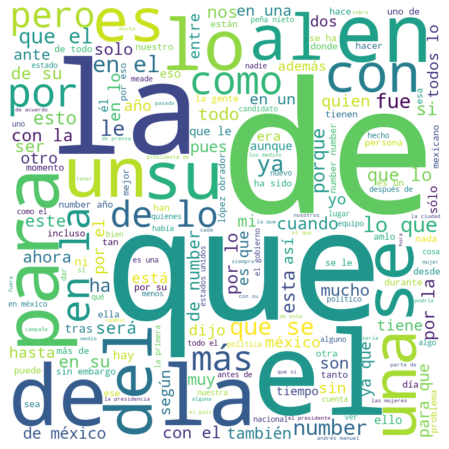

In [8]:
plot_wordcloud(fake_words)

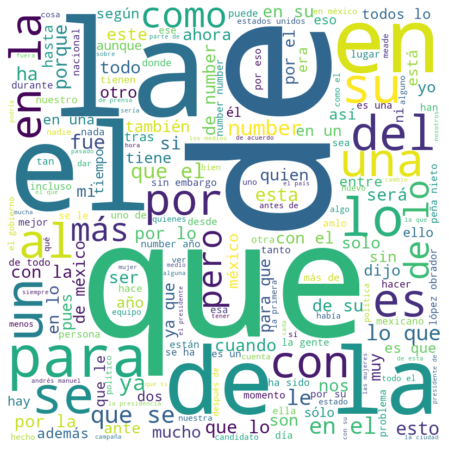

In [9]:
plot_wordcloud(real_words)

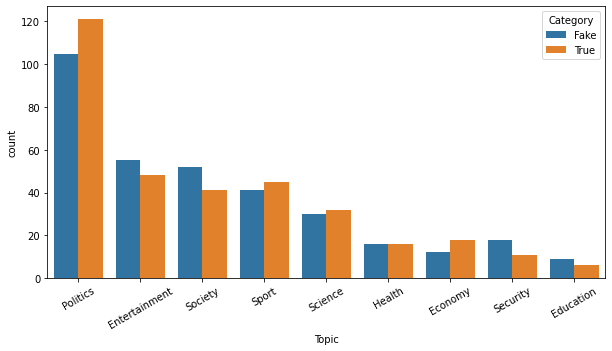

In [10]:
plt.figure(figsize=(10,5))
sns.countplot(x='Topic', hue='Category', data=train, 
              order = train['Topic'].value_counts().index);
plt.xticks(rotation=30);


* As we can see from the above BarPlot that the data has non-uniform distribution over the topic of news so it might be better to drop this column.

New sample:

In [11]:
train['Headline'][1]

'La palabra "haiga", aceptada por la RAE'

In [12]:
train['Text'][1]

'La palabra "haiga", aceptada por la RAE La Real Academia de la Lengua (RAE), ha aceptado el uso de "HAIGA", para su utilización en las tres personas del singular del presente del subjuntivo del verbo hacer, aunque asegura que la forma más recomendable en la lengua culta para este tiempo, sigue siendo "haya".\nAsí lo han confirmado fuentes de la RAE, que explican que este cambio ha sido propuesto y aprobado por el pleno de la Academia de la Lengua, tras la extendida utilización por todo el territorio nacional, sobre todo, empleado por personas carentes de estudios o con estudios básicos de graduado escolar. Ya no será objeto de burla ese compañero que a diario repite aquello de "Mientras que haiga faena, no podemos quejarnos" o esa abuela que repite aquello de "El que haiga sacao los juguetes, que los recoja".\nEntre otras palabras novedosas que ha aceptado la RAE, contamos también con "Descambiar", significa deshacer un cambio, por ejemplo "devolver la compra". Visto lo visto, nadie a

* Headline is already included in the main text 

## Fake News Detection

We are going to evaluate three feature representations:
* Bag-of-words
* n-grams
* POS tags n-grams

First, let's create some preprocessing functions for the data transforming pipeline

In [13]:
from sklearn.base import BaseEstimator, TransformerMixin
import re
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
nlp = spacy.load('es_core_news_sm')


class TextPreprocessing(BaseEstimator, TransformerMixin):
    def __init__(self, remove_punctuation=True, remove_stopwords=True,
                lemmatization=True, lowercase=True):
        self.remove_punctuation = remove_punctuation
        self.remove_stopwords = remove_stopwords
        self.lemmatization = lemmatization
        self.lowercase = lowercase
        
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_transformed = []
        for idx, text in enumerate(X):
            prepared_text = ""
            if self.lowercase:
                text = text.lower()
            doc = nlp(text, disable=['tagger','parser', 'ner', 'textcat'])
            for word in doc:
                if self.remove_stopwords and word.is_stop:
                    continue
                if self.remove_punctuation and word.is_punct:
                    continue
                if self.lemmatization:
                    word = word.lemma_
                prepared_text += " " + str(word)
            X_transformed.append(prepared_text)
        return np.array(X_transformed)

In [14]:
TextPreprocessing().fit_transform(train['Text'][0:10])[0]

' raer incluir palabra lady diccionario idioma español definición mujer problemático \n españa.- presidente real academia españolar raer darío villanueva conferenciar prensar a mes incluir término lady palabra diccionario idioma español \n darío lady servir definir a mujer problemático o a mujer causar problema y palabra utilizar idioma inglés castellano significar \n contar palabra idioma inglés utilizar español significar globalización personar comenzar a adoptar término anglosajón utilizar significar real casar expresión lady significar idioma original dama inglés usar definir a mujer problemático o acostumbrar causar problema y alboroto \n gente decirle lady a fémina causar escándalo agresivo o provocar tipo problema término dejar considerarse palabra exclusivo idioma inglés incluir diccionario lengua españolar pasar palabra oficial castellano significar distinto confesar \n villanueva presentar a medio definición oficial aparecer diccionario señalar \n -lady \n anglosajón ænglisc 

### Bag of words

In [15]:
X_train = train['Text'].copy()
y_train = train['Category'].copy()

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score, GridSearchCV

pipeline = Pipeline([
    ('preprocess', TextPreprocessing(remove_punctuation=True,
                                    remove_stopwords=False,
                                    lemmatization=False,
                                    lowercase=True)),
    ('vectorizer', CountVectorizer(max_features=3000)),
    #('tfidf', TfidfTransformer()),
    ('model', LogisticRegression())
])

In [17]:
scores = cross_val_score(pipeline, X_train, y_train, cv=5)
scores.mean()

0.8210239651416122

* CV: 0.82
* CV+Tfidf: 0.78
* It seems that performs better without tfidf

### n-grams

We can count n-grams instead of individual words using 'ngram_range' parameter in the CountVectorizer

In [21]:
pipeline.set_params(vectorizer__ngram_range=(2,2)) # bigrams

Pipeline(steps=[('preprocess',
                 TextPreprocessing(lemmatization=False,
                                   remove_stopwords=False)),
                ('vectorizer',
                 CountVectorizer(max_features=3000, ngram_range=(2, 2))),
                ('model', LogisticRegression())])

In [22]:
scores = cross_val_score(pipeline, X_train, y_train, cv=5)
scores.mean()

0.764727668845316

In [23]:
pipeline.set_params(vectorizer__ngram_range=(3,3)) # trigrams

Pipeline(steps=[('preprocess',
                 TextPreprocessing(lemmatization=False,
                                   remove_stopwords=False)),
                ('vectorizer',
                 CountVectorizer(max_features=3000, ngram_range=(3, 3))),
                ('model', LogisticRegression())])

In [24]:
scores = cross_val_score(pipeline, X_train, y_train, cv=5)
scores.mean()

0.7277342047930283

* It performs worst with n-grams

## Model Selection and Parameter Tuning

Let's use GridSearchCV with some classfication models in order to find best parameters for our pipeline. We are going to test all these combinations of parameters:
   * Feature representation: BoW, bigrams and trigrams
   * Lemmatization: Yes/no
   * Stopwords: removing or not
   
We try different classification models such as SVM, Logistic Regression, Random Forest and Boosting

### Logistic Regression

In [25]:
from sklearn.svm import SVC

In [26]:
pipeline.set_params(model=LogisticRegression())
param_grid = [{
    'preprocess__remove_stopwords':[True, False],
    'preprocess__lemmatization':[True, False],
    'vectorizer__ngram_range':[(1,1), (2,2), (3,3)],
}]

grid_search = GridSearchCV(pipeline, param_grid, cv=5,
                           scoring='accuracy', verbose=1, 
                           n_jobs=-1)

In [27]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   57.6s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.6min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        TextPreprocessing(lemmatization=False,
                                                          remove_stopwords=False)),
                                       ('vectorizer',
                                        CountVectorizer(max_features=3000,
                                                        ngram_range=(3, 3))),
                                       ('model', LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'preprocess__lemmatization': [True, False],
                          'preprocess__remove_stopwords': [True, False],
                          'vectorizer__ngram_range': [(1, 1), (2, 2), (3, 3)]}],
             scoring='accuracy', verbose=1)

In [28]:
grid_search.best_score_, grid_search.best_params_

(0.8210239651416122,
 {'preprocess__lemmatization': False,
  'preprocess__remove_stopwords': False,
  'vectorizer__ngram_range': (1, 1)})

### SVM

In [29]:
pipeline.set_params(model=SVC())
param_grid = [{
    'preprocess__remove_stopwords':[True, False],
    'preprocess__lemmatization':[True, False],
    'vectorizer__ngram_range':[(1,1), (2,2), (3,3)],
}]
grid_search = GridSearchCV(pipeline, param_grid, cv=5,
                           scoring='accuracy', verbose=1, 
                           n_jobs=-1)

In [30]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   59.2s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.6min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        TextPreprocessing(lemmatization=False,
                                                          remove_stopwords=False)),
                                       ('vectorizer',
                                        CountVectorizer(max_features=3000,
                                                        ngram_range=(3, 3))),
                                       ('model', SVC())]),
             n_jobs=-1,
             param_grid=[{'preprocess__lemmatization': [True, False],
                          'preprocess__remove_stopwords': [True, False],
                          'vectorizer__ngram_range': [(1, 1), (2, 2), (3, 3)]}],
             scoring='accuracy', verbose=1)

In [31]:
grid_search.best_score_, grid_search.best_params_

(0.7750762527233116,
 {'preprocess__lemmatization': False,
  'preprocess__remove_stopwords': False,
  'vectorizer__ngram_range': (1, 1)})

### Random Forest

In [32]:
from sklearn.ensemble import RandomForestClassifier

In [33]:
pipeline.set_params(model=RandomForestClassifier())
param_grid = [{
    'preprocess__remove_stopwords':[True, False],
    'preprocess__lemmatization':[True, False],
    'vectorizer__ngram_range':[(1,1), (2,2), (3,3)],
}]
grid_search = GridSearchCV(pipeline, param_grid, cv=5,
                           scoring='accuracy', verbose=1, 
                           n_jobs=-1)

In [34]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.6min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        TextPreprocessing(lemmatization=False,
                                                          remove_stopwords=False)),
                                       ('vectorizer',
                                        CountVectorizer(max_features=3000,
                                                        ngram_range=(3, 3))),
                                       ('model', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid=[{'preprocess__lemmatization': [True, False],
                          'preprocess__remove_stopwords': [True, False],
                          'vectorizer__ngram_range': [(1, 1), (2, 2), (3, 3)]}],
             scoring='accuracy', verbose=1)

In [35]:
grid_search.best_score_, grid_search.best_params_

(0.798769063180828,
 {'preprocess__lemmatization': False,
  'preprocess__remove_stopwords': True,
  'vectorizer__ngram_range': (1, 1)})

### Boosting

In [36]:
from sklearn.ensemble import GradientBoostingClassifier

In [37]:
pipeline.set_params(model=GradientBoostingClassifier())
param_grid = [{
    'preprocess__remove_stopwords':[True, False],
    'preprocess__lemmatization':[True, False],
    'vectorizer__ngram_range':[(1,1), (2,2), (3,3)],
}]
grid_search = GridSearchCV(pipeline, param_grid, cv=5,
                           scoring='accuracy', verbose=1, 
                           n_jobs=-1)

In [38]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.7min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        TextPreprocessing(lemmatization=False,
                                                          remove_stopwords=False)),
                                       ('vectorizer',
                                        CountVectorizer(max_features=3000,
                                                        ngram_range=(3, 3))),
                                       ('model',
                                        GradientBoostingClassifier())]),
             n_jobs=-1,
             param_grid=[{'preprocess__lemmatization': [True, False],
                          'preprocess__remove_stopwords': [True, False],
                          'vectorizer__ngram_range': [(1, 1), (2, 2), (3, 3)]}],
             scoring='accuracy', verbose=1)

In [39]:
grid_search.best_score_, grid_search.best_params_

(0.8002723311546841,
 {'preprocess__lemmatization': True,
  'preprocess__remove_stopwords': False,
  'vectorizer__ngram_range': (1, 1)})

* LogReg: 0.82
* SVM: 0.77
* RF: 0.79
* Boosting: 0.80

All the models best accuracy is with grams of length 1

In [27]:
final_pipeline = Pipeline([
    ('preprocess', TextPreprocessing(remove_punctuation=True,
                                    remove_stopwords=False,
                                    lemmatization=False,
                                    lowercase=True)),
    ('vectorizer', CountVectorizer(max_features=3000)),
    ('model', LogisticRegression())
])

param_grid = [{
    'preprocess__remove_stopwords':[True, False],
    'preprocess__lemmatization':[True, False],
    'model__C':[1, 10, 100, 1000, 10000]
}]

log_reg_grid = GridSearchCV(final_pipeline, param_grid, cv=5,
                           scoring='accuracy', verbose=1, 
                           n_jobs=-1)
log_reg_grid.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   49.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.5min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        TextPreprocessing(lemmatization=False,
                                                          remove_stopwords=False)),
                                       ('vectorizer',
                                        CountVectorizer(max_features=3000)),
                                       ('model', LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'model__C': [1, 10, 100, 1000, 10000],
                          'preprocess__lemmatization': [True, False],
                          'preprocess__remove_stopwords': [True, False]}],
             scoring='accuracy', verbose=1)

In [28]:
log_reg_grid.best_score_, log_reg_grid.best_params_

(0.8210239651416122,
 {'model__C': 1,
  'preprocess__lemmatization': False,
  'preprocess__remove_stopwords': False})

In [29]:
best_model = log_reg_grid.best_estimator_

In [30]:
pipeline = Pipeline([
    ('preprocess', TextPreprocessing(remove_punctuation=True,
                                    remove_stopwords=False,
                                    lemmatization=False,
                                    lowercase=True)),
    ('vectorizer', CountVectorizer(max_features=3000)),
])

In [53]:
X_train = pipeline.fit_transform(train['Text'])
y_train = train['Category'].copy()
X_test = pipeline.transform(test['Text'])
y_test = test['Category'].copy()

In [55]:
log_reg = LogisticRegression(C=1)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

In [58]:
from sklearn.metrics import accuracy_score
accuracy_score(y_pred, y_test)

0.7830508474576271

In [43]:
#import pickle 
#with open('model.tk', 'wb') as model_file:
    #pickle.dump(best_model, model_file)

In [44]:
#with open('pipeline.tk', 'wb') as pipeline_file:
    #pickle.dump(final_pipeline, pipeline_file)

In [5]:
import pickle
import preprocessing
from preprocessing import TextPreprocessing

In [6]:
with open('models/pipeline.tk', 'rb') as pickle_file:
        pipeline = pickle.load(pickle_file)

In [7]:
pipeline

Pipeline(steps=[('preprocess',
                 TextPreprocessing(lemmatization=False,
                                   remove_stopwords=False)),
                ('vectorizer', CountVectorizer(max_features=3000)),
                ('model', LogisticRegression())])

In [11]:
all_data = pd.concat([train, test])

In [13]:
pipeline.fit(all_data['Text'], all_data['Category'])

Pipeline(steps=[('preprocess',
                 TextPreprocessing(lemmatization=False,
                                   remove_stopwords=False)),
                ('vectorizer', CountVectorizer(max_features=3000)),
                ('model', LogisticRegression())])

In [19]:
pipeline.predict([test['Text'].iloc[0]])

array(['Fake'], dtype=object)

In [16]:
test['Category'].iloc[0:3]

0    Fake
1    True
2    True
Name: Category, dtype: object

In [17]:
#with open('pipeline.tk', 'wb') as file:
 #   pickle.dump(pipeline, file)

In [20]:
test['Text'].iloc[0]

'MAESTRA DE *NUMBER* AÑOS QUE TUVO RELACIONES CON UN ALUMNO DE *NUMBER* DARÁ EDUCACIÓN SEXUAL EN EL CONALEP\nEstados Unidos.- Luego de que se revelará el caso de una maestra estadounidense de *NUMBER* años de nombre Alexandria Vera que fue acusada de abusar de uno de sus alumno de *NUMBER* años (con quien tuvo un noviazgo e incluso quedó embarazada), el juez que analizó la situación finalmente determinó que la profesora no será encarcelada pero si deberá pagar una multa de USD*NUMBER* mil dólares, alejarse del adolescente para siempre, y dar un servicio comunitario de *NUMBER* horas como profesora en un CONALEP de la Ciudad de México.\nEl juez señala que el chico involucrado confesó que "tuvo relaciones con su consentimiento" y además sus papás aprobaban el noviazgo:\n"Es un caso que llamó la atención de los medios internacionales porque ella tiene *NUMBER* y es muy atractiva, y él es un joven de apenas *NUMBER* años.\nComo el juez que iba a determinar el castigo sentía la presión de m